# Goal

* making a heatmap of l2fc values for incorprator OTUs
  * grouping by pvclust cluster ID

# Setting variables

In [42]:
import os
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [149]:
%%R
workDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/l2fc_pvclust_htmp/'
figDir = '/home/nick/notebook/fullCyc/figures/incorporators/l2fc_pvclust_htmp/'

# log2 fold change
l2fcResDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/'
l2fcResFile = file.path(l2fcResDir, 'l2fc_sparse-maxRejH.txt')

# physeq file
physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/phyloseq/'
physeqBulk = 'bulk-norm-core' 

# params
padj.cutoff = 0.05   # adjusted p-value cutoff for selecting incorporators
nprocs = 24

# Init

In [151]:
%Rpull workDir
workDir = workDir[0]
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
%Rpull figDir
figDir = figDir[0]
if not os.path.isdir(figDir):
    os.makedirs(figDir)    
    
%cd $workDir    

/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/l2fc_pvclust_htmp


In [45]:
%%R
library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
library(ComplexHeatmap)

# Loading files

## l2fc table

In [46]:
%%R 
# log2 fold change analysis results file
df.l2fc = read.delim(l2fcResFile, sep='\t') %>%
    mutate(Rank2 = gsub('^__', '', Rank2),
           Rank3 = gsub('^__', '', Rank3),
           Rank4 = gsub('^__', '', Rank4),
           Rank5 = gsub('^__', '', Rank5),
           Rank6 = gsub('^__', '', Rank6),
           Rank7 = gsub('^__', '', Rank7))
df.l2fc %>% head(n=3)

  Substrate Day Microcosm_replicate sparsity_threshold      OTU log2FoldChange
1   13C-Ami   1                   2               0.25  OTU.514    -0.67802374
2   13C-Ami   1                   2               0.25  OTU.816    -0.06751225
3   13C-Ami   1                   2               0.25 OTU.1099    -0.01965210
          p padj    Rank1          Rank2               Rank3
1 0.9999869    1 Bacteria Proteobacteria Deltaproteobacteria
2 0.9839460    1 Bacteria Proteobacteria Deltaproteobacteria
3 0.9867221    1 Bacteria  Acidobacteria               32-21
                 Rank4          Rank5      Rank6                Rank7 Rank8
1    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
2    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
3 uncultured_bacterium           <NA>       <NA>                 <NA>  <NA>


## prefractionation abundances

In [56]:
%%R 
F = file.path(physeqDir, physeqBulk)
physeq.bulk = readRDS(F)
physeq.bulk.m = physeq.bulk %>% sample_data

physeq.bulk = prune_samples(physeq.bulk.m$Substrate %in% c('12C-Con'), physeq.bulk) %>% 
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.bulk.m = physeq.bulk %>% sample_data


df.bulk = physeq.bulk %>% otu_table %>% as.data.frame
df.bulk$OTU = rownames(df.bulk)
df.bulk$OTU = NULL
colnames(df.bulk) = gsub('.+(D[0-9]+).+', '\\1', colnames(df.bulk))
df.bulk %>% head(n=3) 

                    D3          D14          D48          D6           D1
OTU.12972 9.605225e-05 0.0000000000 0.000000e+00 0.000000000 0.0000000000
OTU.514   0.000000e+00 0.0002570033 6.791171e-05 0.000269179 0.0008603736
OTU.816   2.881568e-04 0.0000000000 0.000000e+00 0.000269179 0.0001229105
                   D30
OTU.12972 0.0000000000
OTU.514   0.0001361656
OTU.816   0.0000000000


# Selecting incorporators

In [6]:
%%R

df.inc = df.l2fc %>%
    filter(padj < padj.cutoff)

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

Total number of incorporator OTUs: 418 


In [7]:
%%R
df.l2fc = df.l2fc %>% 
    mutate(Incorporator = (padj < padj.cutoff) %>% as.numeric) 
df.l2fc %>% head(n=3)

  Substrate Day Microcosm_replicate sparsity_threshold      OTU log2FoldChange
1   13C-Ami   1                   2               0.25  OTU.514    -0.67802374
2   13C-Ami   1                   2               0.25  OTU.816    -0.06751225
3   13C-Ami   1                   2               0.25 OTU.1099    -0.01965210
          p padj    Rank1          Rank2               Rank3
1 0.9999869    1 Bacteria Proteobacteria Deltaproteobacteria
2 0.9839460    1 Bacteria Proteobacteria Deltaproteobacteria
3 0.9867221    1 Bacteria  Acidobacteria               32-21
                 Rank4          Rank5      Rank6                Rank7 Rank8
1    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
2    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
3 uncultured_bacterium           <NA>       <NA>                 <NA>  <NA>
  Incorporator
1            0
2            0
3            0


# l2fc matrix

In [8]:
%%R 
# selecting all incorporator OTUs, keeping l2fc values for all substrates/days

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

df.l2fc.w = df.l2fc %>%
    filter(OTU %in% df.inc$OTU) %>%
    mutate(Day = gsub('^', 'D', Day)) %>%
    unite(Substrate_Day, Substrate, Day, sep='_') %>%
    dplyr::select(OTU, Substrate_Day, log2FoldChange) %>%
    spread(Substrate_Day, log2FoldChange, fill=0) 
rownames(df.l2fc.w) = df.l2fc.w$OTU
df.l2fc.w$OTU = NULL

df.l2fc.w %>% nrow %>% print
df.l2fc.w %>% head(n=3)

Total number of incorporator OTUs: 418 
[1] 418
           13C-Ami_D1 13C-Ami_D14 13C-Ami_D3 13C-Ami_D6 13C-Cel_D14 13C-Cel_D3
OTU.1     -0.01820865   0.1739515 -0.3314178 -0.6235129 -0.54059364 -0.2302009
OTU.10019  0.61441986  -0.2550232  0.2052660 -0.9731104  3.90597961  0.8263626
OTU.1002   0.00000000  -1.0709669  0.0000000  0.0000000  0.03407083  0.0000000
          13C-Cel_D30 13C-Cel_D48 13C-Cel_D6 13C-Glu_D1 13C-Glu_D14 13C-Glu_D3
OTU.1       0.1457742   0.3395559 -0.4822453  1.2098681   0.5253327  0.2585179
OTU.10019   1.6166713  -0.1469741  0.5798252  0.1360641  -1.0149975  0.0000000
OTU.1002    2.8229272  -0.2068126  0.0000000  0.0000000  -1.3953232  0.0000000
           13C-Glu_D6 13C-Gly_D1 13C-Gly_D14 13C-Gly_D3 13C-Gly_D6 13C-Lac_D1
OTU.1     -0.01600647  0.8641228   0.4527054 -0.8361779 -0.4264192  0.9301583
OTU.10019 -0.95787122  0.4955757   1.1851210  1.0199176 -0.1613348  0.1663213
OTU.1002   0.00000000  0.0000000   0.2485669  0.0000000  0.0000000  0.0000000
        

## pvclust

Creating a temporary cluster...done:
socket cluster with 39 nodes on host ‘localhost’
Multiscale bootstrap... Done.


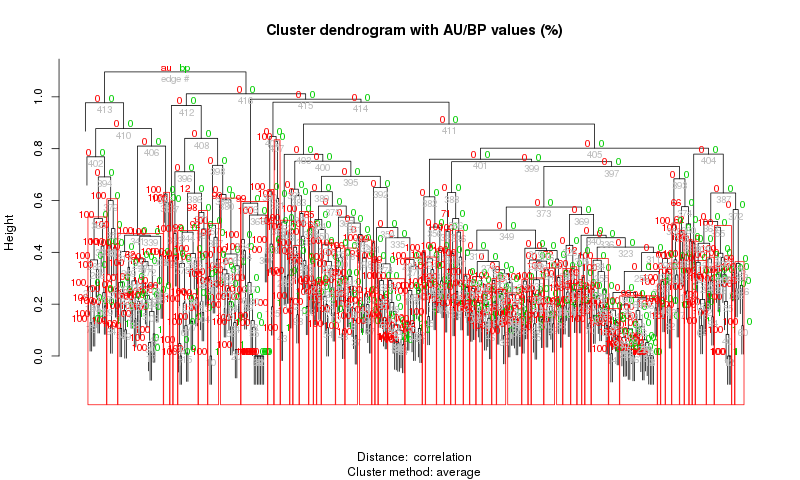

In [25]:
%%R -w 800 
pvc.res = pvclust::pvclust(df.l2fc.w %>% t, 
                           method.hclust='average', 
                           method.dist='correlation',
                           nboot=10000, 
                           parallel=TRUE)
plot(pvc.res, labels=FALSE)
pvclust::pvrect(pvc.res)

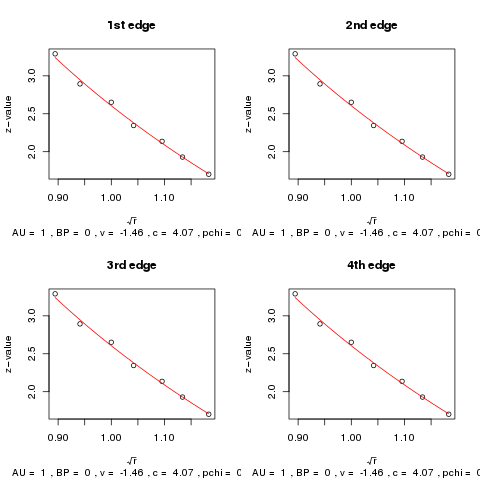

In [26]:
%%R
pvclust::msplot(pvc.res, edges=c(1,2,3,4))

In [27]:
%%R
# number of significant clusters
pvc.clusts = pvclust::pvpick(pvc.res)
pvc.clusts$clusters %>% length

[1] 68


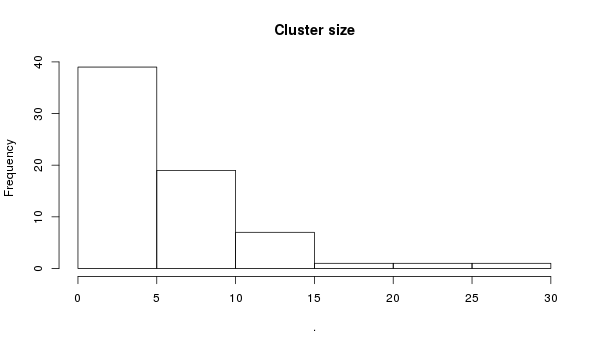

In [28]:
%%R -w 600 -h 350
# size of each cluster
do.call(rbind, lapply(pvc.clusts$clusters, length)) %>% 
    as.vector %>% 
    hist(binwidth=1, main='Cluster size')

In [29]:
%%R
# making dataframe of clusters
clusts = matrix(ncol=2)
for(i in 1:length(pvc.clusts$clusters)){
    x = pvc.clusts$clusters[[i]]
    x = x %>% as.matrix
    x = cbind(x, rep(i, nrow(x)))
    clusts = rbind(clusts, x)
}
df.pvc.clusts = clusts[2:nrow(clusts),] %>% as.data.frame
colnames(df.pvc.clusts) = c('OTU', 'pvc.cluster.ID')
df.pvc.clusts %>% head

        OTU pvc.cluster.ID
1 OTU.10707              1
2  OTU.1073              1
3 OTU.13481              1
4  OTU.2125              1
5  OTU.3812              1
6  OTU.7961              1


## Setting up column ordering/annotation

In [134]:
%%R
# ordering
col.order = c(
"13C-Ami_D1",
"13C-Ami_D3",
"13C-Ami_D6",
"13C-Ami_D14",
"13C-Glu_D1",
"13C-Glu_D3",
"13C-Glu_D6",
"13C-Glu_D14",
"13C-Gly_D1",
"13C-Gly_D3",
"13C-Gly_D6",
"13C-Gly_D14",
"13C-Xyl_D1",
"13C-Xyl_D3",
"13C-Xyl_D6",
"13C-Xyl_D14",
"13C-Lac_D1",
"13C-Lac_D3",
"13C-Lac_D6",
"13C-Oxa_D3",
"13C-Oxa_D6",
"13C-Oxa_D14",
"13C-Van_D6",
"13C-Van_D14",
"13C-Van_D30",
"13C-Van_D48",
"13C-Cel_D3",
"13C-Cel_D6",
"13C-Cel_D14",
"13C-Cel_D30",
"13C-Cel_D48",
"13C-Pal_D6",
"13C-Pal_D14",
"13C-Pal_D30",
"13C-Pal_D48")


In [135]:
%%R -h 250 -w 600
# making column annotation of substrate & day

df.sd = data.frame(Substrate = gsub('_.+', '', col.order),
                   Day = gsub('.+_', '', col.order)) 

Substrate.cols = c(
"13C-Pal" = "#FF0000FF",
"13C-Xyl" = "#FF9900FF",
"13C-Van" = "#CCFF00FF",
"13C-Glu" = "#33FF00FF",
"13C-Lac" = "#00FF66FF",
"13C-Cel" = "#00FFFFFF",
"12C-Con" = "#0066FFFF",
"13C-Gly" = "#3300FFFF",
"13C-Ami" = "#CC00FFFF",
"13C-Oxa" = "#FF0099FF"
)

Day.cols = c(
"D1" = "#F2F2F2FF",
"D3" = "#BCBCBCFF",
"D6" = "#8A8A8AFF",
"D14" = "#5A5A5AFF",
"D30" = "#2E2E2EFF",
"D48" = "#000000FF"
)

ha.col = HeatmapAnnotation(df = df.sd, 
  col = list(Substrate = Substrate.cols,
             Day = Day.cols),
  na_col = "grey")


## Row annotation by phylum

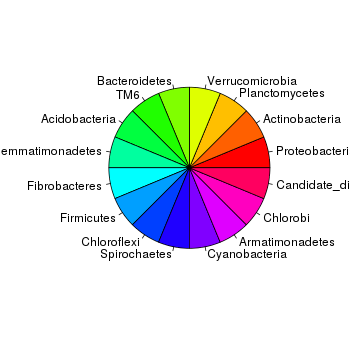

In [136]:
%%R -w 350 -h 350
df.l2fc.phy = df.l2fc %>%
    dplyr::select(OTU, Rank2) %>%
    distinct(OTU, Rank2) 
rownames(df.l2fc.phy) = df.l2fc.phy$OTU

df.l2fc.phy = df.l2fc.phy[rownames(df.l2fc.w),]
df.l2fc.phy = df.l2fc.phy %>%
    dplyr::select(Rank2) %>%
    mutate(Rank2 = Rank2 %>% as.character)

tax = df.l2fc.phy$Rank2 %>% unique
n.tax = tax %>% length
colors = rainbow(n.tax)
tax.cols = setNames(colors, tax)

ha.row = HeatmapAnnotation(df = df.l2fc.phy, 
                           col = list(Rank2 = tax.cols),
                           na_col = 'grey',
                           which='row', 
                           width=unit(4, 'mm'))

pie(rep(1, n.tax), labels=tax, col=colors)

## preFrac heatmap

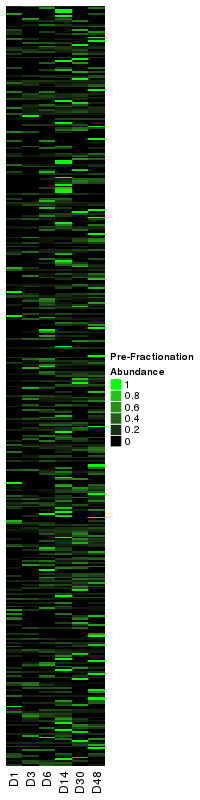

In [137]:
%%R -h 800 -w 200
# adding taxa found in fractions but not in bulk-abundances
not.in = setdiff(rownames(df.l2fc.w), rownames(df.bulk))
df.not.in = matrix(nrow=length(not.in), ncol=ncol(df.bulk)) %>% as.data.frame
colnames(df.not.in) = colnames(df.bulk)
rownames(df.not.in) = not.in
df.not.in[is.na(df.not.in)] = 0

# filtering and ordering
df.bulk.f = rbind(df.bulk, df.not.in)
df.bulk.f = df.bulk.f[rownames(df.l2fc.w),] 

# transforming
df.bulk.f = apply(df.bulk.f, 1, function(x) x / sum(x)) %>% t
df.bulk.f[is.nan(df.bulk.f)] = 0

# column order
pf.col.order = c('D1', 'D3', 'D6', 'D14', 'D30', 'D48')
    
# making heatmap
min.abnd = df.bulk.f %>% as.matrix %>% as.vector %>% min
max.abnd = df.bulk.f %>% as.matrix %>% as.vector %>% max
h.pf = Heatmap(df.bulk.f %>% as.matrix, 
        name='Pre-Fractionation\nAbundance', 
        col = circlize::colorRamp2(c(min.abnd, max.abnd), 
                                   c("black", "green")),
        show_row_names=FALSE,
        combined_name_fun=NULL,
        cluster_columns=FALSE,
        cluster_rows=FALSE,
        column_order=pf.col.order)
h.pf

## Making heatmap

In [138]:
%%R
# dataframe for spliting by pvclust clusterID
df.sp = df.pvc.clusts
rownames(df.sp) = df.sp$OTU %>% as.vector
df.sp = df.sp[rownames(df.l2fc.w),]
df.sp$OTU = NULL
df.sp %>% head(n=4)

          pvc.cluster.ID
OTU.1                 58
OTU.10019             19
OTU.1002              32
OTU.1004              23


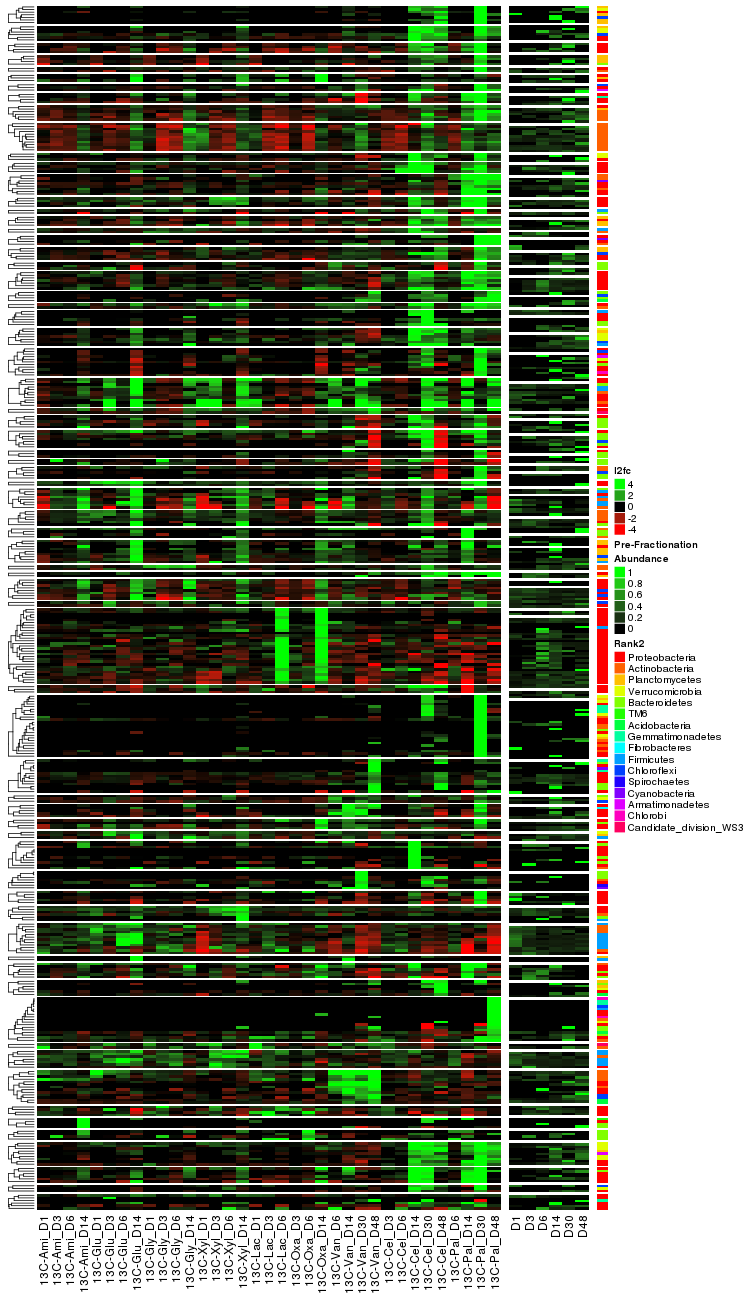

In [139]:
%%R -h 1300 -w 750

h = Heatmap(df.l2fc.w %>% as.matrix, 
        name='l2fc', 
        col = circlize::colorRamp2(c(-3, 0, 3), 
                                   c("red", "black", "green")),
        show_row_names=FALSE,
        split=df.sp,
        combined_name_fun=NULL,
        cluster_columns=FALSE,
        column_order=col.order,
        gap=unit(0.6, "mm"))

h + h.pf + ha.row

### Filtering out low-richness clusters

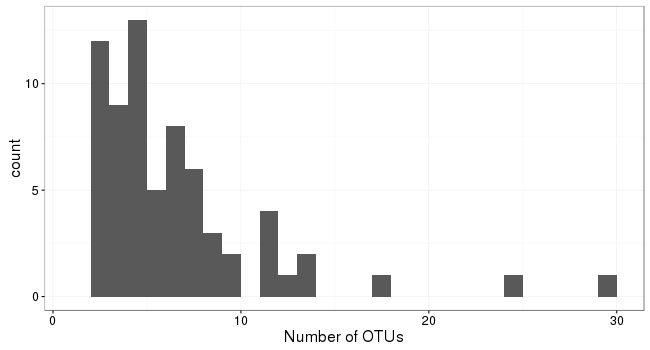

In [140]:
%%R -w 650 -h 350
df.pvc.clusts.s = df.pvc.clusts %>%
    group_by(pvc.cluster.ID) %>%
    summarize(n.OTU = n()) %>%
    ungroup()

ggplot(df.pvc.clusts.s, aes(n.OTU)) +
    geom_histogram(binwidth=1) +
    labs(x='Number of OTUs') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [141]:
%%R
# cutoff for number of OTUs that must be in cluster
n.OTU.cut = 8

df.l2fc.f.w = inner_join(df.l2fc, df.pvc.clusts, c('OTU'='OTU')) %>%
    group_by(pvc.cluster.ID) %>%
    mutate(OTU.per.clust = OTU %>% unique %>% length) %>%
    filter(OTU.per.clust >= n.OTU.cut) %>%
    ungroup() %>%
    mutate(Day = gsub('^', 'D', Day)) %>%
    unite(Substrate_Day, Substrate, Day, sep='_') %>%
    dplyr::select(OTU, Substrate_Day, log2FoldChange) %>%
    spread(Substrate_Day, log2FoldChange, fill=0) 

rownames(df.l2fc.f.w) = df.l2fc.f.w$OTU
df.l2fc.f.w$OTU = NULL
df.l2fc.f.w %>% head(n=3) %>% print

# dataframe for spliting by pvclust clusterID
df.sp = df.pvc.clusts
rownames(df.sp) = df.sp$OTU %>% as.vector
df.sp = df.sp[rownames(df.l2fc.f.w),] 
df.sp$OTU = NULL
df.sp %>% head(n=3) %>% print

Source: local data frame [3 x 35]

  13C-Ami_D1 13C-Ami_D14 13C-Ami_D3 13C-Ami_D6 13C-Cel_D14 13C-Cel_D3
       (dbl)       (dbl)      (dbl)      (dbl)       (dbl)      (dbl)
1  0.0000000   -1.070967   0.000000  0.0000000  0.03407083  0.0000000
2  0.6316796    1.039169  -1.028904 -0.1931768  1.12256841 -0.1763183
3  0.0000000    0.000000   0.000000  0.0000000  0.00000000  0.0000000
Variables not shown: 13C-Cel_D30 (dbl), 13C-Cel_D48 (dbl), 13C-Cel_D6 (dbl),
  13C-Glu_D1 (dbl), 13C-Glu_D14 (dbl), 13C-Glu_D3 (dbl), 13C-Glu_D6 (dbl),
  13C-Gly_D1 (dbl), 13C-Gly_D14 (dbl), 13C-Gly_D3 (dbl), 13C-Gly_D6 (dbl),
  13C-Lac_D1 (dbl), 13C-Lac_D3 (dbl), 13C-Lac_D6 (dbl), 13C-Oxa_D14 (dbl),
  13C-Oxa_D3 (dbl), 13C-Oxa_D6 (dbl), 13C-Pal_D14 (dbl), 13C-Pal_D30 (dbl),
  13C-Pal_D48 (dbl), 13C-Pal_D6 (dbl), 13C-Van_D14 (dbl), 13C-Van_D30 (dbl),
  13C-Van_D48 (dbl), 13C-Van_D6 (dbl), 13C-Xyl_D1 (dbl), 13C-Xyl_D14 (dbl),
  13C-Xyl_D3 (dbl), 13C-Xyl_D6 (dbl)
          pvc.cluster.ID
OTU.1002              

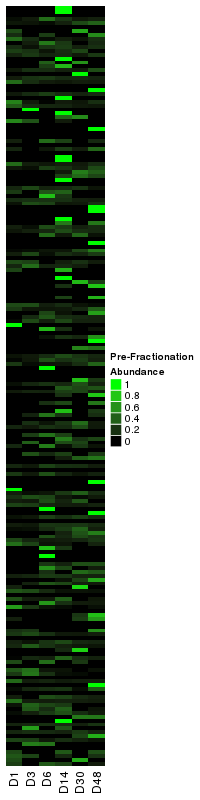

In [143]:
%%R -h 800 -w 200

df.bulk.f = df.bulk.f[rownames(df.l2fc.f.w),] 

# transforming
df.bulk.f = apply(df.bulk.f, 1, function(x) x / sum(x)) %>% t
df.bulk.f[is.nan(df.bulk.f)] = 0

    
# column order
pf.col.order = c('D1', 'D3', 'D6', 'D14', 'D30', 'D48')
    
# making heatmap
min.abnd = df.bulk.f %>% as.matrix %>% as.vector %>% min
max.abnd = df.bulk.f %>% as.matrix %>% as.vector %>% max
h.pf = Heatmap(df.bulk.f %>% as.matrix, 
        name='Pre-Fractionation\nAbundance', 
        col = circlize::colorRamp2(c(min.abnd, max.abnd), 
                                   c("black", "green")),
        show_row_names=FALSE,
        combined_name_fun=NULL,
        cluster_columns=FALSE,
        cluster_rows=FALSE,
        column_order=pf.col.order)
h.pf

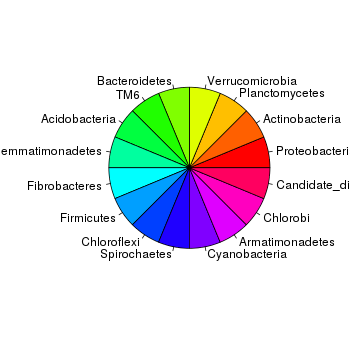

In [147]:
%%R -w 350 -h 350
# taxonomy annotation
df.l2fc.phy = df.l2fc %>%
    dplyr::select(OTU, Rank2) %>%
    distinct(OTU, Rank2) 
rownames(df.l2fc.phy) = df.l2fc.phy$OTU

rownames(df.l2fc.phy) = df.l2fc.phy$OTU
df.l2fc.phy = df.l2fc.phy[rownames(df.l2fc.f.w),]
df.l2fc.phy = df.l2fc.phy %>%
    dplyr::select(Rank2) %>%
    mutate(Rank2 = Rank2 %>% as.character)

ha.row = HeatmapAnnotation(df = df.l2fc.phy, 
                           col = list(Rank2 = tax.cols),
                           na_col = 'grey',
                           which='row', 
                           width=unit(4, 'mm'))

pie(rep(1, n.tax), labels=tax, col=colors)

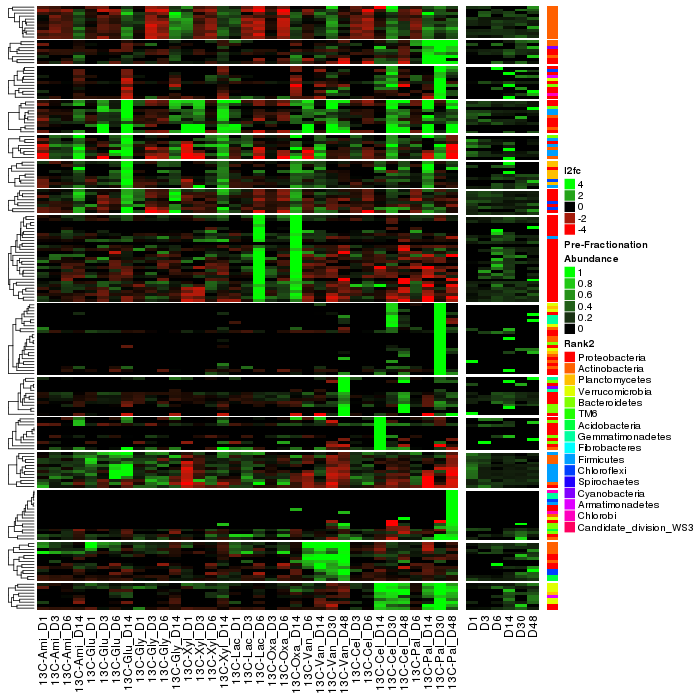

In [153]:
%%R -h 700 -w 700
# heatmap: trimmed

#min.l2fc = df.l2fc.f.w %>% as.vector %>% min
#max.l2fc = df.l2fc.f.w %>% as.vector %>% max

h = Heatmap(df.l2fc.f.w %>% as.matrix, 
        name='l2fc', 
        col = circlize::colorRamp2(c(-3, 0, 3), 
                                   c("red", "black", "green")),
        show_row_names=FALSE,
        split=df.sp,
        combined_name_fun=NULL,
        cluster_columns=FALSE,
        column_order=col.order,
        gap=unit(0.6, "mm")
        )

h + h.pf + ha.row

In [167]:
%%R -i figDir

htmp.file = file.path(figDir, 'htmp_nOTUcut8.pdf')
pdf(htmp.file, width=10, height=11)
draw(h + h.pf + ha.row)
dev.off()
cat('File written:', htmp.file, '\n')


htmp.file = file.path(figDir, 'htmp_nOTUcut8.tiff')
tiff(htmp.file, width=10, height=11, units='in', res=150)
draw(h + h.pf + ha.row)
dev.off()
cat('File written:', htmp.file, '\n')

File written: /home/nick/notebook/fullCyc/figures/incorporators/l2fc_pvclust_htmp//htmp_nOTUcut8.pdf 
File written: /home/nick/notebook/fullCyc/figures/incorporators/l2fc_pvclust_htmp//htmp_nOTUcut8.tiff 


# Plotting l2fc dynamics for each pvclust clust

In [39]:
%%R

df.l2fc.pvc = inner_join(df.pvc.clusts, df.l2fc, c('OTU' = 'OTU'))

df.l2fc.pvc.s = df.l2fc.pvc %>%
    group_by(Substrate, Day, pvc.cluster.ID) %>%
    summarize(median_l2fc = median(log2FoldChange)) %>%
    ungroup() %>%
    complete(Substrate, Day, pvc.cluster.ID) %>%
    mutate(median_l2fc = ifelse(is.na(median_l2fc), 0, median_l2fc))



# majority rule
maj.rule = function(x){
    y = x %>% table %>% sort(decreasing=TRUE) %>% names
    y[1] 
}
df.maj.rule = df.l2fc.pvc %>% 
    filter(Incorporator == 1) %>%
    group_by(pvc.cluster.ID) %>%
    summarize(Day.maj.rule = maj.rule(Day),
              Sub.maj.rule = maj.rule(Substrate)) %>%
    ungroup() %>%
    unite(maj.rule, Day.maj.rule, Sub.maj.rule, sep='_', remove=FALSE) %>%
    mutate(maj.rule = gsub('^', 'D', maj.rule))

df.l2fc.pvc.s = inner_join(df.l2fc.pvc.s, df.maj.rule, c('pvc.cluster.ID' = 'pvc.cluster.ID')) 


df.l2fc.pvc.s$pvc.cluster.ID = reorder(df.l2fc.pvc.s$pvc.cluster.ID, 
                                       df.l2fc.pvc.s$pvc.cluster.ID %>% as.numeric)

df.l2fc.pvc.s %>% head

Source: local data frame [6 x 7]

  Substrate   Day pvc.cluster.ID median_l2fc    maj.rule Day.maj.rule
     (fctr) (int)         (fctr)       (dbl)       (chr)        (chr)
1   13C-Ami     1              1  0.00000000 D30_13C-Pal           30
2   13C-Ami     1             10  0.43282265 D30_13C-Cel           30
3   13C-Ami     1             11 -0.25962597 D30_13C-Pal           30
4   13C-Ami     1             12 -1.38840076 D30_13C-Pal           30
5   13C-Ami     1             13 -0.04824186 D30_13C-Pal           30
6   13C-Ami     1             14  1.25491531 D14_13C-Glu           14
Variables not shown: Sub.maj.rule (chr)


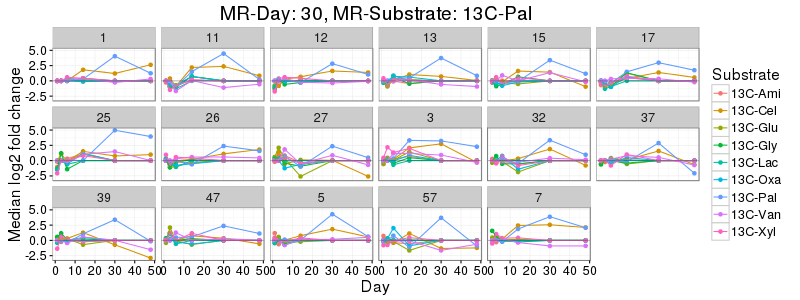

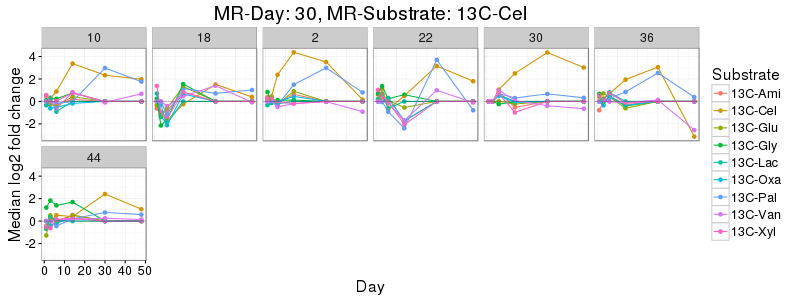

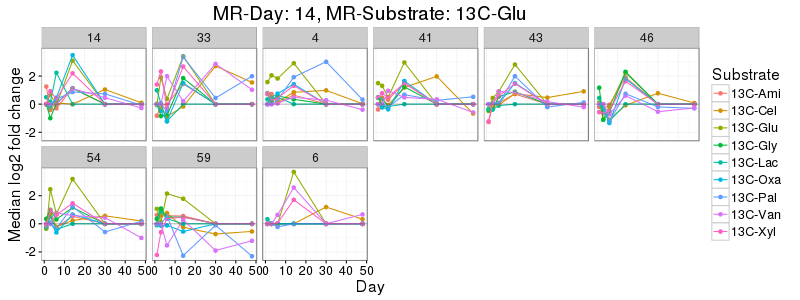

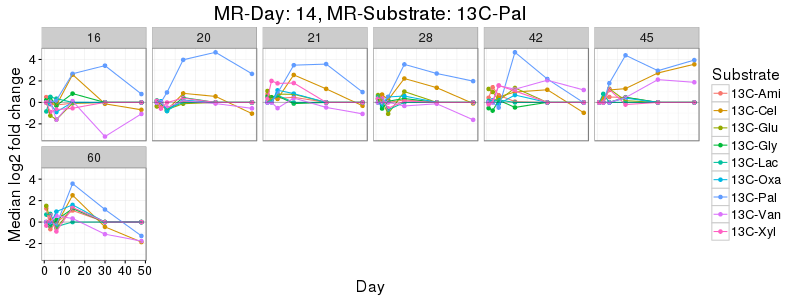

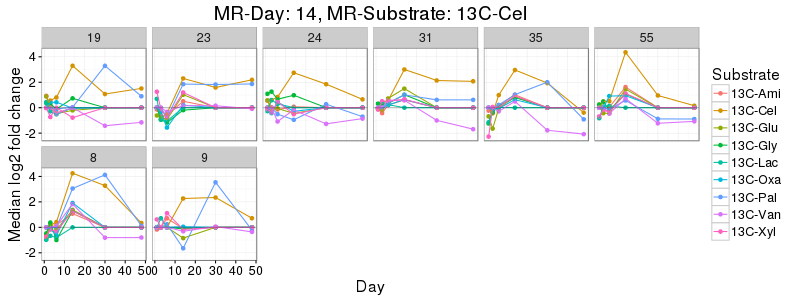

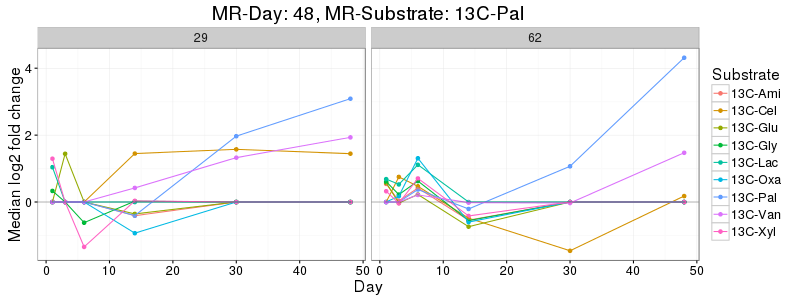

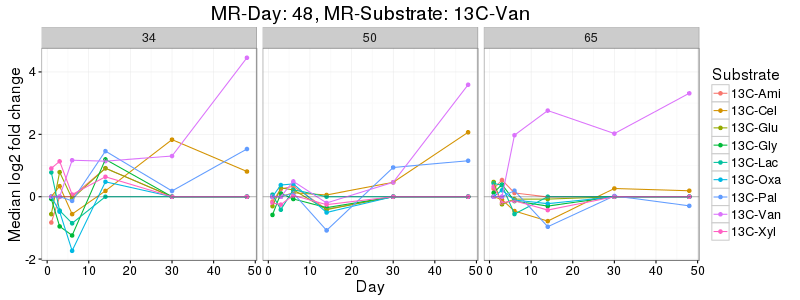

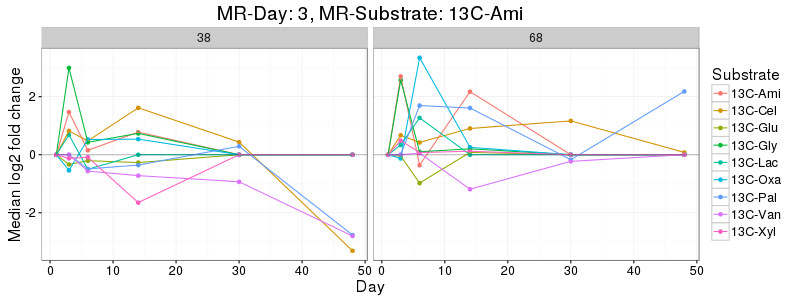

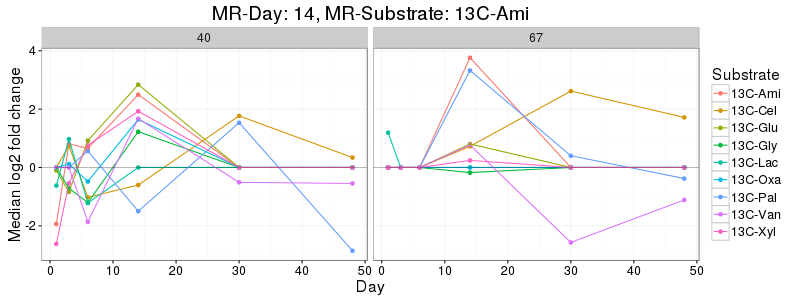

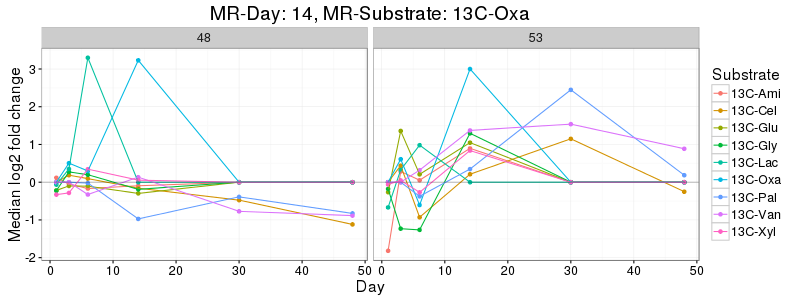

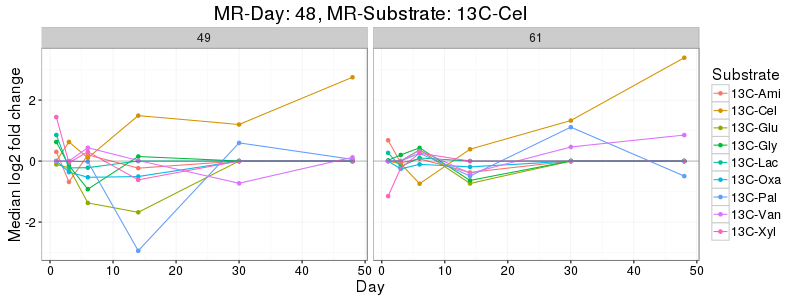

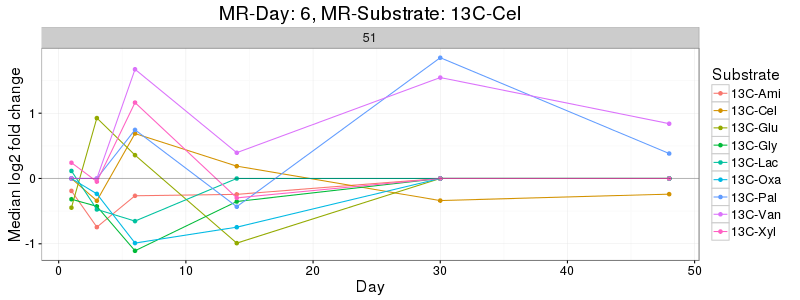

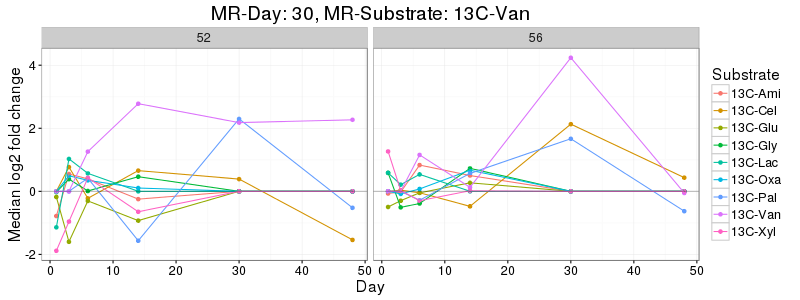

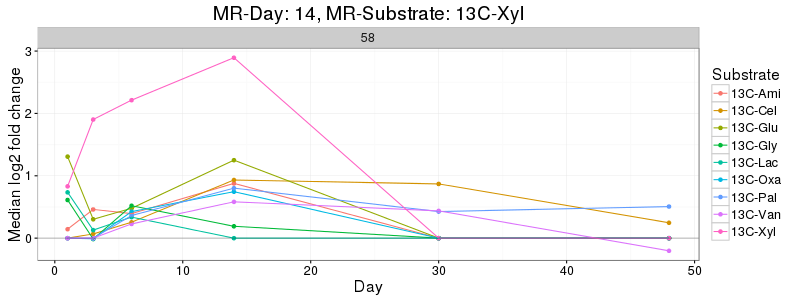

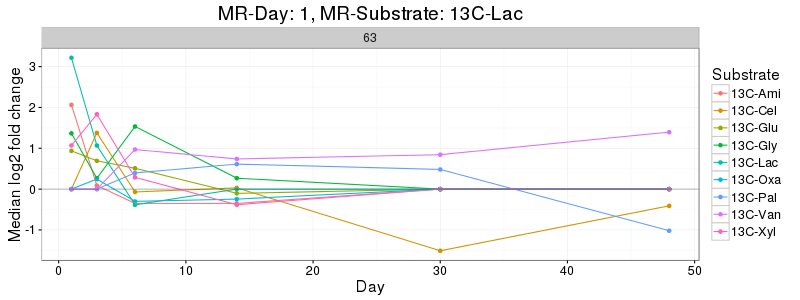

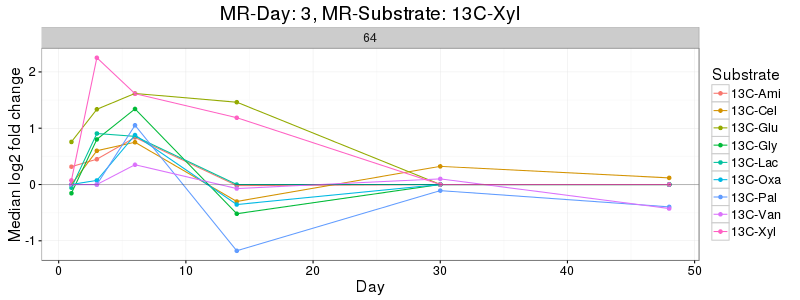

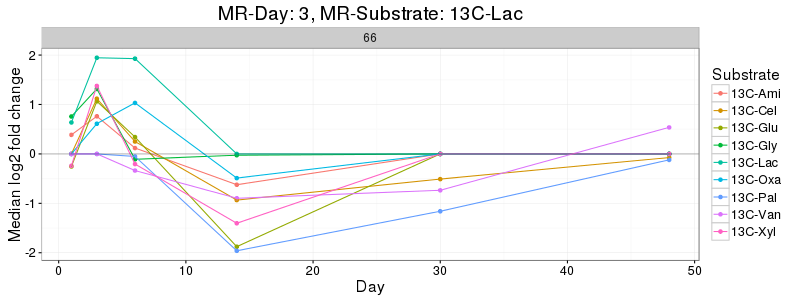

In [40]:
%%R -w 800 -h 300

make.plot = function(df, Day){
    Day.maj.rule = df$Day.maj.rule2 %>% unique
    Sub.maj.rule = df$Sub.maj.rule2 %>% unique
    title = paste0('MR-Day: ', Day.maj.rule, ', MR-Substrate: ', Sub.maj.rule, collapse=' ')
    
    p = ggplot(df, aes(Day, median_l2fc, color=Substrate)) +
        geom_point() +
        geom_line() +
        geom_hline(yintercept=0, alpha=0.25) +
        labs(y='Median log2 fold change', title=title) +
        facet_wrap(~ pvc.cluster.ID, ncol=6) +
        theme_bw() +
        theme(
            text = element_text(size=16)
        )
    print(p)
    return(1)
}


df.l2fc.pvc.s.p = df.l2fc.pvc.s %>% 
    mutate(Day.maj.rule2 = Day.maj.rule, 
           Sub.maj.rule2 = Sub.maj.rule) %>%
    group_by(Day.maj.rule, Sub.maj.rule) %>%
    nest %>%
    mutate(plot = lapply(data, make.plot, Day = Day.maj.rule))

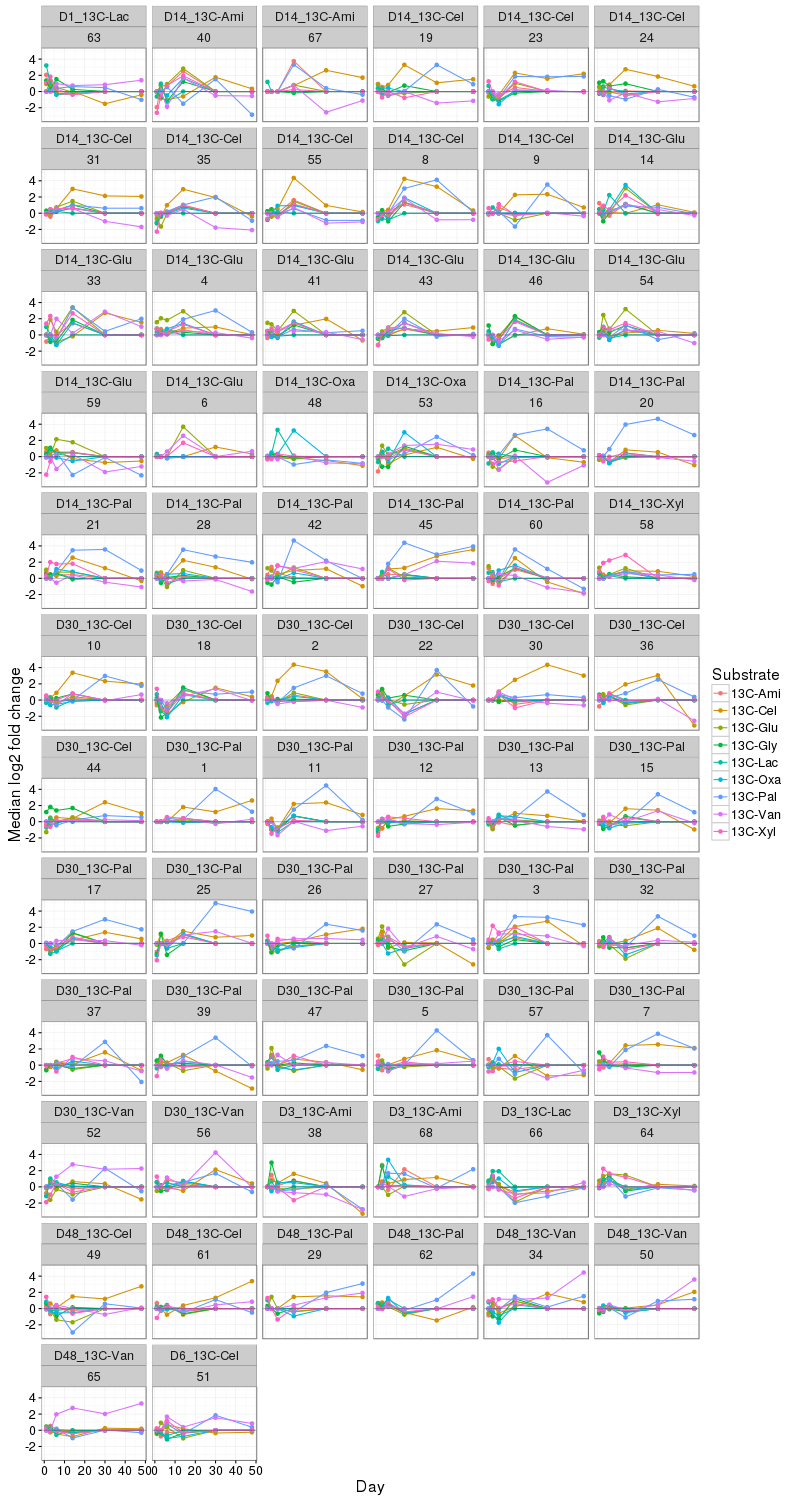

In [41]:
%%R -w 800 -h 1500

ggplot(df.l2fc.pvc.s, aes(Day, median_l2fc, color=Substrate)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept=0, alpha=0.25) +
    labs(y='Median log2 fold change') +
    facet_wrap(maj.rule ~ pvc.cluster.ID, ncol=6) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )